In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Potato Disease Classification

In [2]:
# import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Dataset Collection

In [4]:
# laod the dataset by using tensorflow pipeline
my_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato Disease Classification/PlantVillage",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 2158 files belonging to 3 classes.


In [5]:
# getting the folder_names/class_names
class_name = my_dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
# showing the length of the dataset 68 just because we divide the dataset into batches above 32*68 = 2152
len(my_dataset)

68

(32, 256, 256, 3)


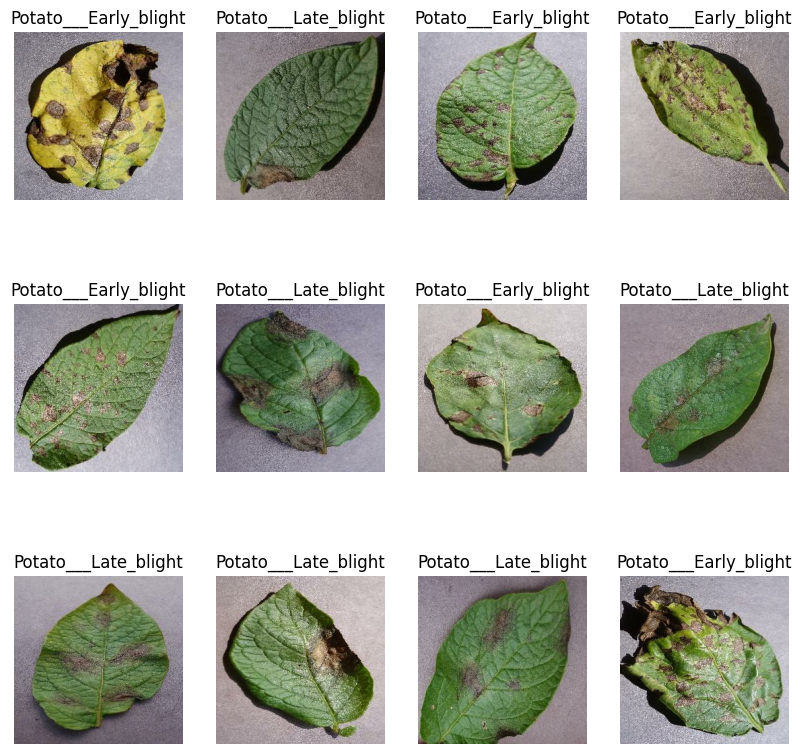

In [7]:
# Displaying the some random images of all classes
for image_batch, label_batch in my_dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_name[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
    print(image_batch.shape)


# Split tha dataset into train, test and validation by the ratio of 80%,10% and 10%

In [8]:
# geting the 80% of the training data that is 54 out 68
train_size = 0.8
len(my_dataset)*train_size

54.400000000000006

In [9]:
train_dataset = my_dataset.take(54)
len(train_dataset)

54

In [10]:
# geting the 10% of the testing data that is 14 out 68
test_dataset = my_dataset.skip(54)
len(test_dataset)

14

In [11]:
val_size = 0.1
len(my_dataset)*val_size

6.800000000000001

In [12]:
# geting the 10% of the validation data that is 6 out 15
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [13]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [14]:
# Now create a pipeline that return the training, testing and validation dataset by calculating it using above logic
def get_dataset_pertitions_tf(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

# Display the lentgh of each data to ensure the correct split

In [15]:
train_dataset, val_dataset, test_dataset = get_dataset_pertitions_tf(my_dataset)

In [16]:
len(train_dataset)

54

In [17]:
len(test_dataset)

8

In [18]:
len(val_dataset)

6

In [19]:
# This cell save the trainig time by prefetching the data
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Dataset Preprocessing

In [20]:
# resizing and rescaling the images with the help of tensorflow
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
# Apply data augmentation on the images with the help of tensorflow
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Implement Convolutional Neural Network : Model building

In [22]:
# Define the CNN layers according to the architecture  
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    # convolution layer 1 + pooling layer 1
    layers.Conv2D(32, (3,3), activation="relu", input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    # convolution layer 2 + pooling layer 2
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    # convolution layer 3 + pooling layer 3
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    # convolution layer 4 + pooling layer 4
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    # convolution layer 5 + pooling layer 5
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    # convolution layer 6 + pooling layer 6
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    # Flatten layer
    layers.Flatten(),
    # Hidden layer
    layers.Dense(64, activation="relu"),
    # Output layer
    layers.Dense(3, activation="softmax")
])

model.build(input_shape=(32, 256, 256, 3))

In [23]:
# Display the model detail summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [25]:
# Train the model with following params
history = model.fit(
    train_dataset,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=val_dataset)

Epoch 1/30
54/54 [==============================] - 617s 209ms/step - loss: 0.9031 - accuracy: 0.4919 - val_loss: 0.8543 - val_accuracy: 0.4740
Epoch 2/30
54/54 [==============================] - 3s 62ms/step - loss: 0.7113 - accuracy: 0.6638 - val_loss: 0.4744 - val_accuracy: 0.8333
Epoch 3/30
54/54 [==============================] - 3s 63ms/step - loss: 0.4166 - accuracy: 0.8235 - val_loss: 0.4768 - val_accuracy: 0.7969
Epoch 4/30
54/54 [==============================] - 3s 64ms/step - loss: 0.2861 - accuracy: 0.8860 - val_loss: 0.4034 - val_accuracy: 0.8125
Epoch 5/30
54/54 [==============================] - 3s 62ms/step - loss: 0.2451 - accuracy: 0.9057 - val_loss: 0.2469 - val_accuracy: 0.8698
Epoch 6/30
54/54 [==============================] - 3s 62ms/step - loss: 0.2487 - accuracy: 0.9132 - val_loss: 0.4536 - val_accuracy: 0.8125
Epoch 7/30
54/54 [==============================] - 3s 63ms/step - loss: 0.1438 - accuracy: 0.9444 - val_loss: 0.2396 - val_accuracy: 0.9010
Epoch 8/30

# Model Evaluation

In [30]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 0s 28ms/step - loss: 0.0367 - accuracy: 0.9844


In [31]:
scores

[0.03666296601295471, 0.984375]

# Properties of keras history callback

In [32]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.49189814925193787,
 0.6637731194496155,
 0.8234953880310059,
 0.8859953880310059,
 0.9056712985038757,
 0.9131944179534912,
 0.9444444179534912,
 0.9670138955116272,
 0.9710648059844971,
 0.9728009104728699,
 0.9658564925193787,
 0.9722222089767456,
 0.9745370149612427,
 0.9832175970077515,
 0.9693287014961243,
 0.984375,
 0.9791666865348816,
 0.9785879850387573,
 0.9693287014961243,
 0.9814814925193787,
 0.9901620149612427,
 0.9762731194496155,
 0.9878472089767456,
 0.9751157164573669,
 0.9884259104728699,
 0.9866898059844971,
 0.96875,
 0.9884259104728699,
 0.9774305820465088,
 0.9809027910232544]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visulizing Loss and Accuracy

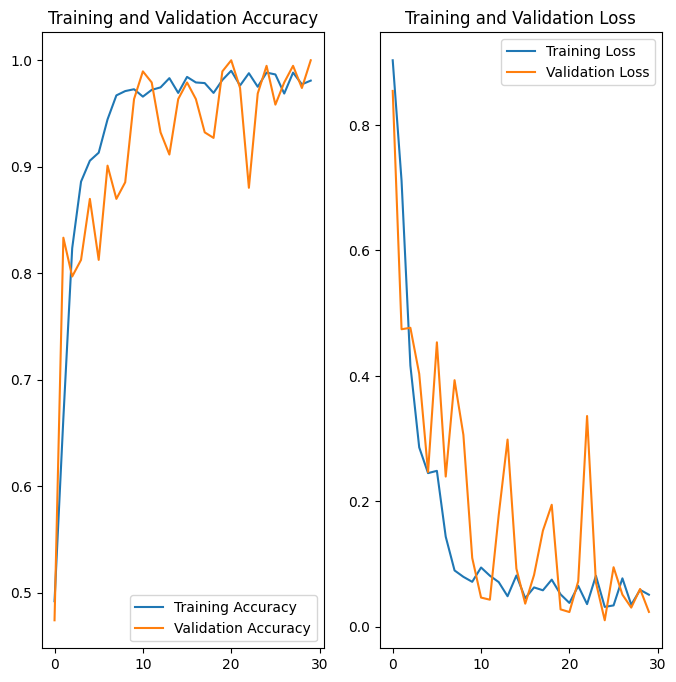

In [36]:
# Display the Accuracy of training and validation dataset
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Display the loss of training and validation dataset
plt.subplot(1,2,2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Prediction

actual class: Potato___Late_blight
1/1 [==============================] - 0s 42ms/step
predicted class: Potato___Late_blight


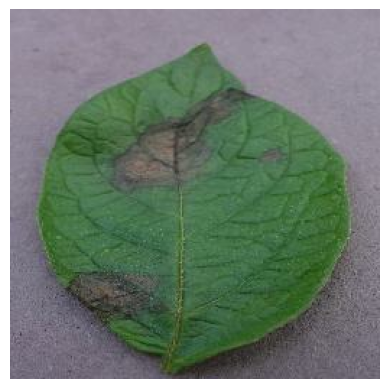

In [41]:
import numpy as np
# Predicting the True label and predicted label of one test_samaple
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual class:", class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted class:", class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')


In [79]:
# Predicting the True labels and predicted labels of multiple test_samaple
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images_batch[i].numpy().astype('uint8'))
    plt.axis("off")

    predtiction = model.predict(images)
    predicted_class = class_name[np.argmax(predtiction[i])]
    confidence = round(100 * (np.max(predtiction[i])), 2)
    actual_class = class_name[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")


Output hidden; open in https://colab.research.google.com to view.

# Saving the model according to the versions

In [89]:
import os
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Potato Disease Classification/models")])+1
model.save(f"/content/drive/MyDrive/Potato Disease Classification/models/{model_version}")